In [1]:
import yfinance as yf
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy as dp
from sklearn.preprocessing import MinMaxScaler

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [170]:
data = yf.download("EURPLN=X", start="1990-01-01", end="2024-09-08")

[*********************100%***********************]  1 of 1 completed


In [171]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-04-01,3.59320,3.62610,3.5738,3.57380,3.57380,0
2002-04-02,3.57380,3.61960,3.5738,3.60890,3.60890,0
2002-04-03,3.60280,3.61100,3.5840,3.60430,3.60430,0
2002-04-04,3.60020,3.61320,3.5903,3.59860,3.59860,0
2002-04-05,3.59400,3.60360,3.5833,3.59290,3.59290,0
...,...,...,...,...,...,...
2024-08-29,4.29350,4.29705,4.2791,4.29350,4.29350,0
2024-08-30,4.28292,4.28676,4.2712,4.28292,4.28292,0
2024-09-02,4.28686,4.28807,4.2632,4.28686,4.28686,0


In [242]:
class DataPreProcess():
  def __init__(self,
               df:pd.DataFrame,
               pred_column:str,
               windows,
               columns,
               scaler
               ):
    self.df = dp(df)
    self.n_features = len(columns)
    self.columns = columns
    self.pred_column = pred_column
    self.scaler = scaler
    self.windows = windows
    self.prepare_df()
    self.shift_data()

  def prepare_df(self):
    plt.figure(figsize=(30,7))
    plt.title('Before Quantile')
    plt.subplot(1,2,1)
    for i in range(self.n_features):
      plt.plot(self.df[self.columns[i]],label=self.columns[i])

    for i in range(self.n_features):
      self.df = self.df[(self.df[self.columns[i]] < self.df.quantile(0.999)[self.columns[i]]) & (self.df[self.columns[i]] >self.df.quantile(0.001)[self.columns[i]])]

    plt.subplot(1,2,2)
    plt.title('After Quantile')
    for i in range(self.n_features):
      plt.plot(self.df[self.columns[i]],label=self.columns[i])

    plt.legend()

    self.df = self.df[self.columns]


  def shift_data(self):

    features = self.columns

    shiffted_df = []
    for i in range(1,self.windows+1):
      shiffted = self.df[features].shift(i)
      shiffted.columns = [f"{feature} n-{i}" for feature in features]
      shiffted_df.append(shiffted)


    features.remove(self.pred_column)
    self.df.drop(columns=features,inplace=True)

    df_s = pd.concat([self.df]+shiffted_df,axis=1)
    df_s.dropna(inplace=True)
    df_s.columns = [df_s.columns[0]] + df_s.columns[1:][::-1].tolist()
    df_s.iloc[:,1:] = df_s.iloc[:,:0:-1]
    self.df = df_s


  def preprocess_df(self):

    df_n = self.df.to_numpy()

    scaler = self.scaler()
    df_n_scaled = scaler.fit_transform(df_n)

    X = torch.tensor(df_n_scaled[:,1:]).float()
    y = torch.tensor(df_n_scaled[:,0]).float()

    idx = int(len(X) * 0.80)

    X_train, X_test = X[:idx], X[idx:]
    y_train, y_test = y[:idx], y[idx:]

    X_train = X_train.reshape((-1,self.windows,self.n_features))
    X_test = X_test.reshape((-1,self.windows,self.n_features))
    y_train = y_train.reshape((-1,1))
    y_test = y_test.reshape((-1,1))

    return X_train, X_test, y_train, y_test

<ipython-input-172-cef27c7bc6a1>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(torch.Size([4613, 20, 1]),
 torch.Size([1154, 20, 1]),
 torch.Size([4613, 1]),
 torch.Size([1154, 1]))

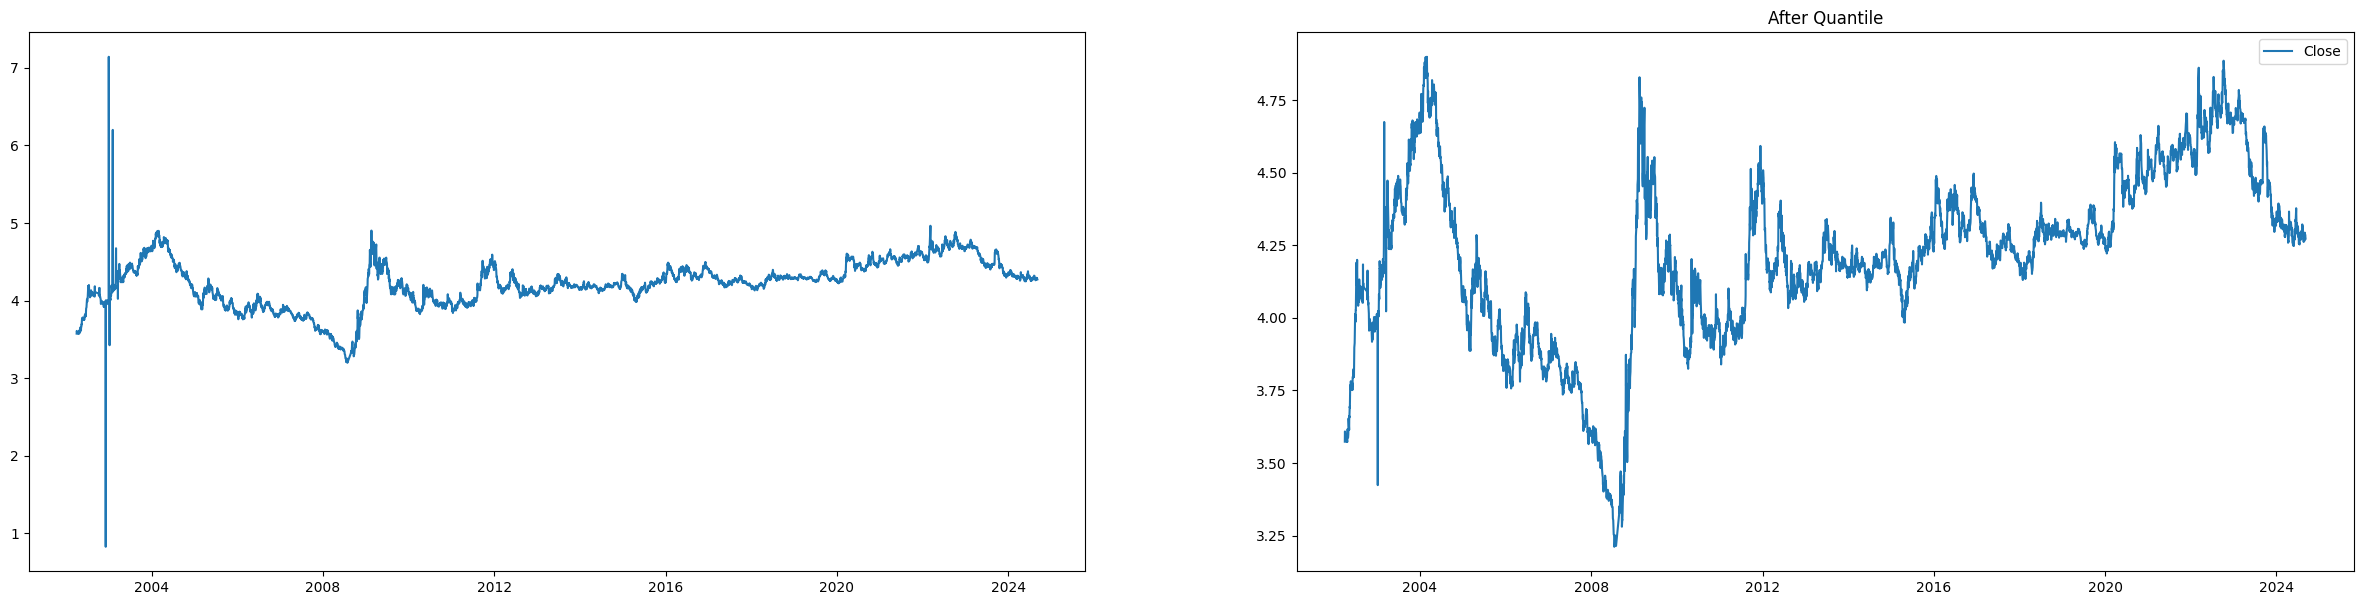

In [173]:
data_one_f = DataPreProcess(
    df = data,
    pred_column='Close',
    windows=20,
    columns=['Close'],
    scaler=MinMaxScaler
)

X_train_o, X_test_o, y_train_o,y_test_o = data_one_f.preprocess_df()
X_train_o.shape,X_test_o.shape,y_train_o.shape,y_test_o.shape

<ipython-input-6-c45397bb45e1>:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


(torch.Size([4572, 20, 5]),
 torch.Size([1144, 20, 5]),
 torch.Size([4572, 1]),
 torch.Size([1144, 1]))

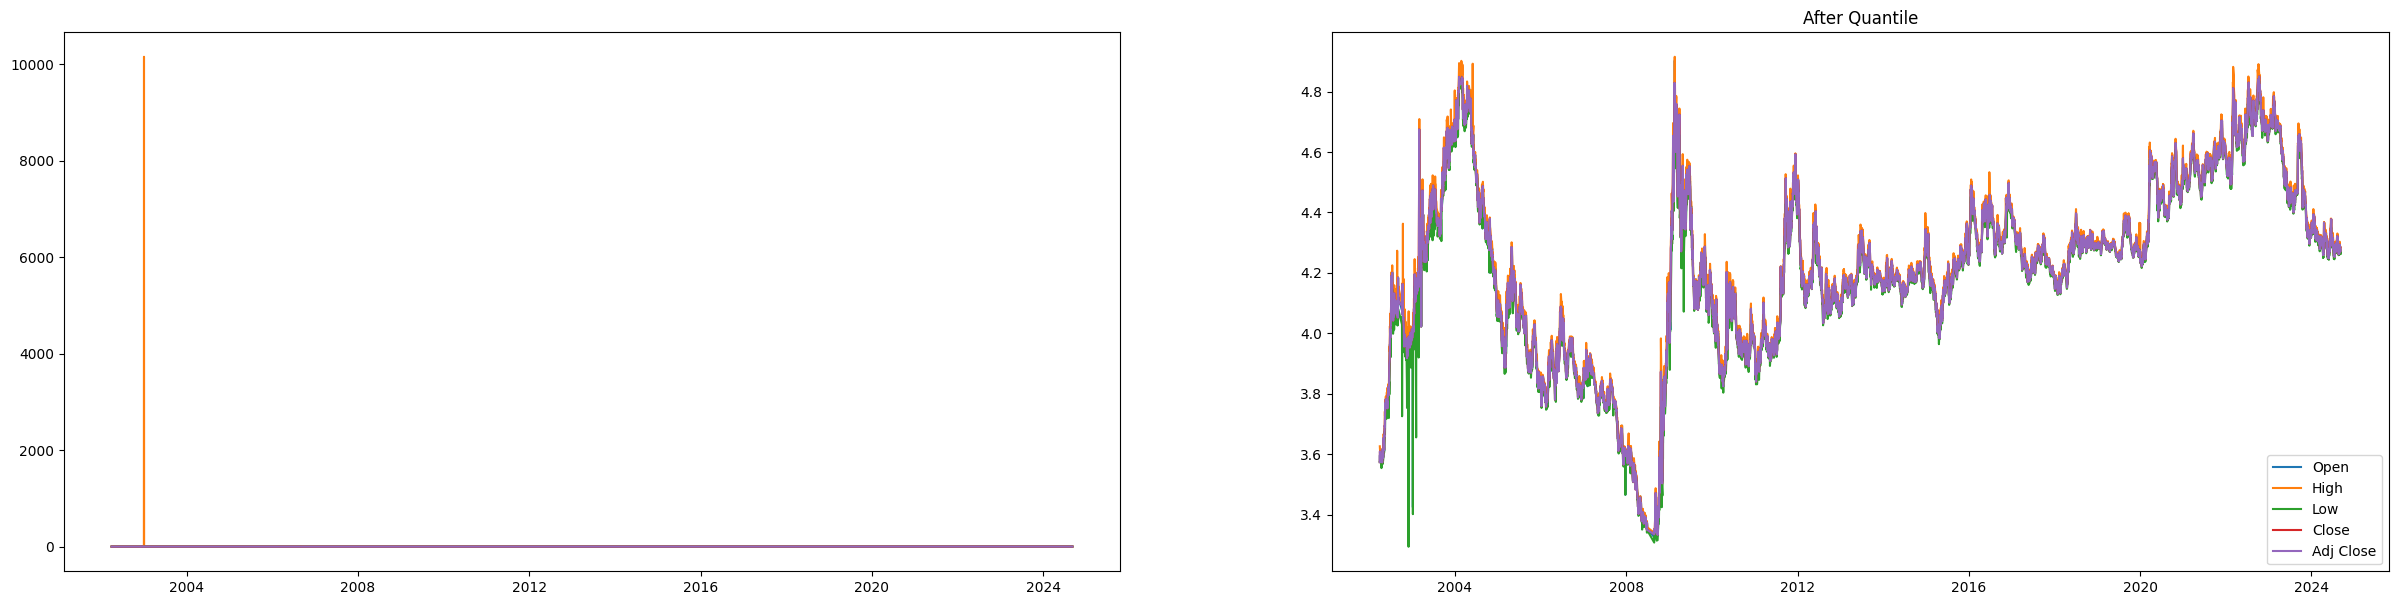

In [8]:
data_five_f = DataPreProcess(
    df = data,
    pred_column='Close',
    windows=20,
    columns=['Open','High','Low','Close','Adj Close'],
    scaler=MinMaxScaler
)
X_train_f, X_test_f, y_train_f, y_test_f = data_five_f.preprocess_df()
X_train_f.shape, X_test_f.shape, y_train_f.shape, y_test_f.shape

In [9]:
from torch.utils.data import Dataset,DataLoader


class CustomDataset(Dataset):
  def __init__(self,X,y):
    super().__init__()
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index:int):
    return self.X[index], self.y[index]


In [10]:
train_data_o = CustomDataset(X_train_o,y_train_o)
test_data_o = CustomDataset(X_test_o,y_test_o)

train_data_f = CustomDataset(X_train_f,y_train_f)
test_data_f = CustomDataset(X_test_f,y_test_f)

In [11]:
train_dataloader_o = DataLoader(
    dataset=train_data_o,
    batch_size=32,
    shuffle=True
)

test_dataloader_o = DataLoader(
    dataset=test_data_o,
    batch_size=32,
    shuffle=False
)

train_dataloader_f = DataLoader(
    dataset=train_data_f,
    batch_size=32,
    shuffle=True
)

test_dataloader_f = DataLoader(
    dataset=test_data_f,
    batch_size=32,
    shuffle=False
)

In [108]:
import torch
from torch import nn

"""
 - input_size -> number of features
 - hidden_size -> number of hidden units and output shape
 - num_layers -> number of LSTM layers, more layers more complexity
 - batch_first -> if True input and output will be shape (batch_size,seq_len / windows , hidden_size) if false (seq_len,batch_size,hidden_size)

 - h0, c0 -> just to remember

 - Data :
  X should be (batch_size/samples, seq_len / windows, features(input_size))

 out[:,-1,:] -> because we want to use only the last timestamp (out shape higher ^)

 Wy only last ? :
Because LSTMS is remembering what he learned from prev steps so the last time step contains all informations about whole sequence!!!.

"""
class LSTM(nn.Module):
  def __init__(self,input_size,hidden_size,layers):
    super().__init__()
    self.layers = layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size,hidden_size,layers,batch_first=True)
    self.fc = nn.Linear(hidden_size,1)

  def forward(self,X):
    batch_size = X.size(0)
    h0 = torch.zeros(self.layers,batch_size,self.hidden_size).to(device)
    c0 = torch.zeros(self.layers,batch_size,self.hidden_size).to(device)
    out, _ = self.lstm(X, (h0,c0))
    return self.fc(out[:,-1,:])

In [109]:
def train_step(
    model:nn.Module,
    loss_fn :nn.Module,
    optim:torch.optim.Optimizer,
    dataset:torch.utils.data.DataLoader,
    device):

  train_loss = 0
  model.train()
  for i,(X,y) in enumerate(dataset):
    X, y = X.to(device), y.to(device)
    pred = model(X)

    loss = loss_fn(pred,y)
    train_loss += loss.item()
    optim.zero_grad()
    loss.backward()
    optim.step()

  train_loss /= len(dataset)

  return train_loss

def test_step(
    model:nn.Module,
    loss_fn:nn.Module,
    optim:torch.optim.Optimizer,
    dataset:torch.utils.data.DataLoader,
    device):

  test_loss, targets, preds = 0, [], []
  model.eval()
  with torch.inference_mode():
    for X,y in dataset:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred,y)
      test_loss += loss.item()

      targets.append(y)
      preds.append(pred)

    test_loss /= len(dataset)

    return test_loss, targets, preds

In [131]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error,r2_score

def train(
    model:nn.Module,
    loss_fn:nn.Module,
    optim:torch.optim.Optimizer,
    epochs:int,
    train_data:torch.utils.data.DataLoader,
    test_data:torch.utils.data.DataLoader,
    device):

  history = {
      "train_loss" : [],
      "test_loss" : [],
      "r2" : [],
      "mae" : []
  }

  for epoch in tqdm(range(epochs),desc='Training...'):

    train_loss = train_step(
        model=model,
        loss_fn=loss_fn,
        optim=optim,
        dataset=train_data,
        device=device
    )

    test_loss, targets, preds = test_step(
        model=model,
        loss_fn=loss_fn,
        optim=optim,
        dataset=test_data,
        device=device
    )
    preds = torch.cat(preds).cpu()
    targets = torch.cat(targets).cpu()

    mae = mean_absolute_error(targets.numpy(),preds.numpy())
    r2 = r2_score(targets.numpy(),preds.numpy())

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['mae'].append(mae)
    history['r2'].append(r2)

    if epoch % 10 == 0 :
      print(f"Epoch : {epoch} | Loss : {train_loss:.4f} | Val Loss : {test_loss:.4f} | Mae : {mae:.4f} | R2 : {r2:.3f}")

  return history

In [152]:
torch.manual_seed(42)

model_one_feature = LSTM(data_one_f.n_features,6,1).to(device)
model_five_feature = LSTM(data_five_f.n_features,6,1).to(device)

In [153]:
loss_fn = nn.MSELoss()

optim_o = torch.optim.Adam(
    model_one_feature.parameters(),
    lr=0.001
)

optim_f = torch.optim.Adam(
    model_five_feature.parameters(),
    lr=0.001
)

Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | Loss : 0.1580 | Val Loss : 0.0442 | Mae : 0.1988 | R2 : -5.463
Epoch : 10 | Loss : 0.0008 | Val Loss : 0.0006 | Mae : 0.0175 | R2 : 0.918
Epoch : 20 | Loss : 0.0005 | Val Loss : 0.0004 | Mae : 0.0144 | R2 : 0.946
Epoch : 30 | Loss : 0.0004 | Val Loss : 0.0004 | Mae : 0.0154 | R2 : 0.944
Epoch : 40 | Loss : 0.0004 | Val Loss : 0.0002 | Mae : 0.0106 | R2 : 0.972
Epoch : 50 | Loss : 0.0003 | Val Loss : 0.0002 | Mae : 0.0120 | R2 : 0.969
Epoch : 60 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0090 | R2 : 0.979
Epoch : 70 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0084 | R2 : 0.981
Epoch : 80 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0082 | R2 : 0.982
Epoch : 90 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0090 | R2 : 0.979


Training...:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 | Loss : 0.0592 | Val Loss : 0.0127 | Mae : 0.0984 | R2 : -0.499
Epoch : 10 | Loss : 0.0005 | Val Loss : 0.0003 | Mae : 0.0126 | R2 : 0.966
Epoch : 20 | Loss : 0.0004 | Val Loss : 0.0002 | Mae : 0.0111 | R2 : 0.974
Epoch : 30 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0089 | R2 : 0.983
Epoch : 40 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0088 | R2 : 0.984
Epoch : 50 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0078 | R2 : 0.987
Epoch : 60 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0074 | R2 : 0.989
Epoch : 70 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0072 | R2 : 0.989
Epoch : 80 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0096 | R2 : 0.983
Epoch : 90 | Loss : 0.0003 | Val Loss : 0.0001 | Mae : 0.0069 | R2 : 0.990


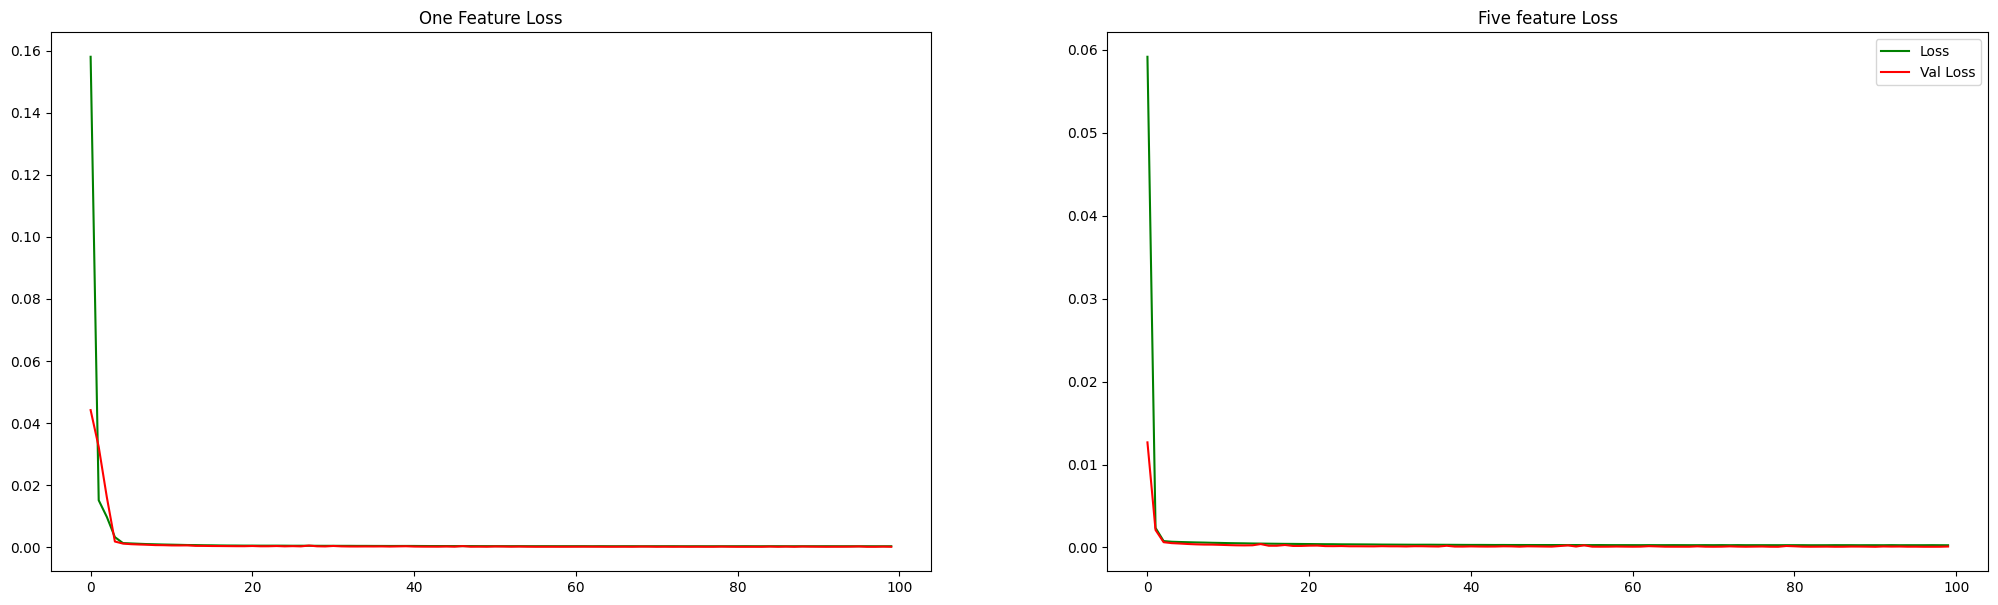

In [154]:
torch.manual_seed(42)

history_one = train(
    model=model_one_feature,
    loss_fn=loss_fn,
    optim=optim_o,
    epochs=100,
    train_data=train_dataloader_o,
    test_data=test_dataloader_o,
    device=device
)

history_five = train(
    model=model_five_feature,
    loss_fn=loss_fn,
    optim=optim_f,
    epochs=100,
    train_data=train_dataloader_f,
    test_data=test_dataloader_f,
    device=device
)


plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
plt.title('One Feature Loss')
plt.plot(history_one['train_loss'],c='g',label='Loss')
plt.plot(history_one['test_loss'],c='r',label='Val Loss')

plt.subplot(1,2,2)
plt.title('Five feature Loss')
plt.plot(history_five['train_loss'],c='g',label='Loss')
plt.plot(history_five['test_loss'],c='r',label='Val Loss')
plt.legend()

In [155]:
def predict(model,X_test,y_test,model_name):
  X_test, y_test = X_test.to(device), y_test.to(device)
  model = model.to(device)
  model.eval()

  with torch.inference_mode():
    preds_test = model(X_test)


  plt.figure(figsize=(30,7))

  plt.title(f'Test predictions for {model_name}')
  plt.plot(y_test.cpu(),c='b',label ='Real')
  plt.plot(preds_test.cpu(),c='y',label='Predicted')
  plt.legend()

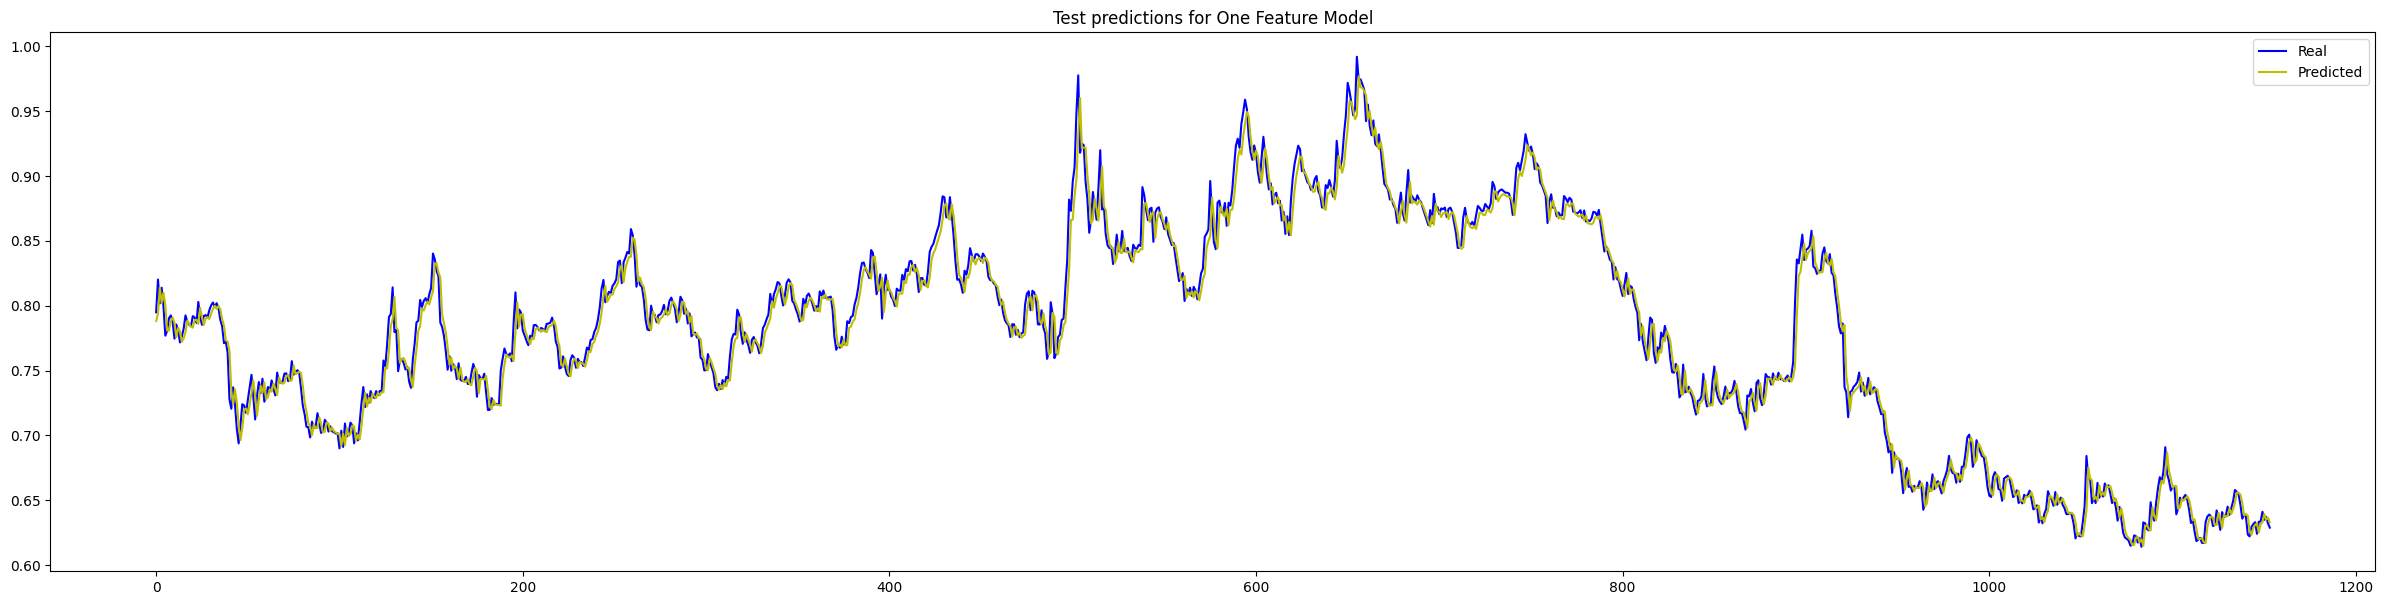

In [156]:
predict(model_one_feature,X_test_o,y_test_o,'One Feature Model')


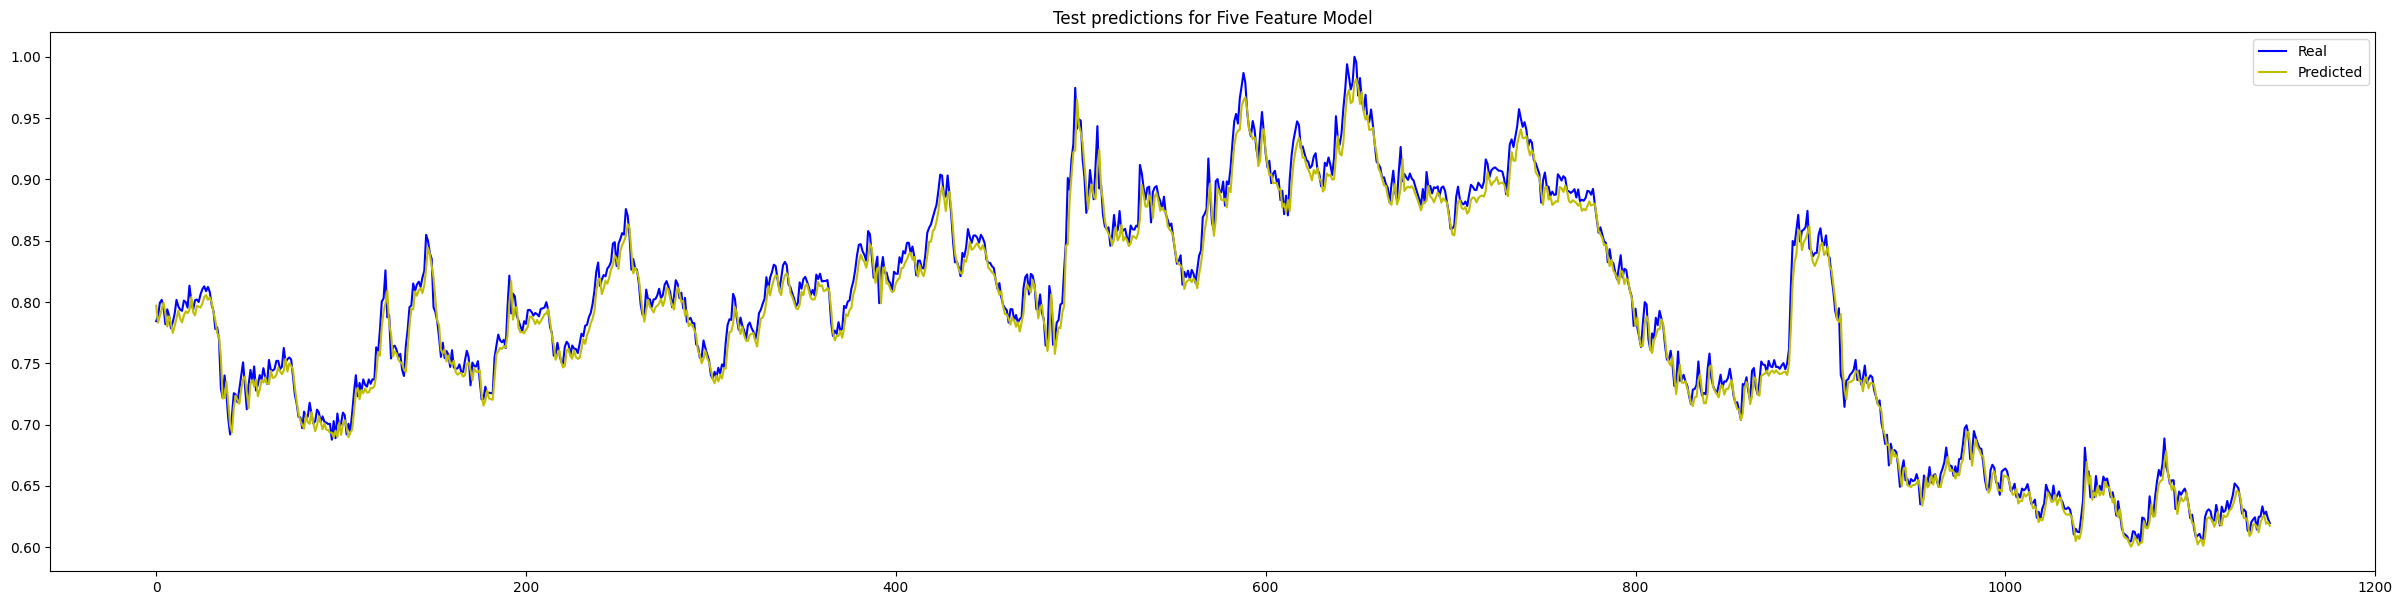

In [157]:
predict(model_five_feature,X_test_f,y_test_f,'Five Feature Model')

In [160]:
from pathlib import Path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = 'polxeur_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_five_feature.state_dict(),f=MODEL_SAVE_PATH)